In [73]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Data Processing
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
import os
os.environ["PATH"] += os.pathsep + 'Users/xxd/anaconda3/lib/python3.9/site-packages/sphinx/templates/graphviz'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# preparing data
from sklearn.decomposition import PCA
from methods import *
from models import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn
from datasetPreProcessing import LoadDatasetByName


model_name = "VAE"
DATASET = 'iiot_data'
DATASET = 'medical_data'
DATASET = 'KDD_10'
#DATASET = 'network_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True                                                                                                                                               
REMOVE_NOISE = False
REMOVE_NOISE_THRESHOLD = 5
DENOISE = False
NOISE_FACTOR = 0.1
NOISE_FRACTION = 0.8
NORMALIZE_DATA = True
NORMALIZATION_SCHEME = 'standard_scaling'
LATENT_DIM = 4
HIDDEN_DIM = 128
WEIGHT_DECAY = 0e-7
LEARNING_RATE = 1e-3
SIGMA = 1e-1
EPOCHS = 1000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'xavier_normal'
ATTENTION = False
ATT_E_DIM = 32
return_dict = {}
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA, normalization_scheme=NORMALIZATION_SCHEME,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)

print(raw_data.shape)
NUM_FEATURE = len(anomalous_data[0])
print(train_data.max())
# select featuress
idc = [1,2,4,5,6]
idc = None
if idc:
    train_data, validation_data, test_data, anomalous_data = train_data[:,idc], validation_data[:,idc], test_data[:,idc], anomalous_data[:,idc]
NUM_FEATURE = len(anomalous_data[0])
print(train_data.shape, anomalous_data.shape)

Untrimmed columns:  [0, 1, 5, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Train data shape after trim:  (58366, 20)
Train data shape after filter corrcoef:  (58366, 19)
Normalization scheme:  standard_scaling
removeNoise = True ---- remaining Data Shape = (55791, 19); noise proportion: 0.04411815097830929
Train data shape after normalize:  (55791, 19)
(97278, 35)
tensor(4.9896)
torch.Size([55791, 19]) torch.Size([396743, 19])


In [75]:
# use VAE to generate from noise to train
criterion = nn.MSELoss(reduction='sum')
attNet = None
if ATTENTION:
    attNet = AttentionNet(num_feature=NUM_FEATURE, sample_size=len(train_data), E_dim=ATT_E_DIM)
    NUM_FEATURE = attNet.E_Dim
model = VAE(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)
# train
print("Attention: ", ATTENTION)
loss_array = train(model, 'SGD', EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e2, att=attNet)
torch.save(model.state_dict(), '../model/param_VAE')

Attention:  False
epoch : 1/1000, loss = 10.075209
epoch : 2/1000, loss = 9.014256
epoch : 3/1000, loss = 8.835677
epoch : 4/1000, loss = 8.700292
epoch : 5/1000, loss = 8.531613
epoch : 6/1000, loss = 8.343699
epoch : 7/1000, loss = 8.158030
epoch : 8/1000, loss = 7.841363
epoch : 9/1000, loss = 7.501781
epoch : 10/1000, loss = 7.195396
epoch : 11/1000, loss = 6.761959
epoch : 12/1000, loss = 6.204800
epoch : 13/1000, loss = 5.502886
epoch : 14/1000, loss = 5.058419
epoch : 15/1000, loss = 4.777135
epoch : 16/1000, loss = 4.511078
epoch : 17/1000, loss = 4.179410
epoch : 18/1000, loss = 3.954820
epoch : 19/1000, loss = 3.857671
epoch : 20/1000, loss = 3.807910
epoch : 21/1000, loss = 3.773671
epoch : 22/1000, loss = 3.734389
epoch : 23/1000, loss = 3.702751
epoch : 24/1000, loss = 3.645469
epoch : 25/1000, loss = 3.581613
epoch : 26/1000, loss = 3.516455
epoch : 27/1000, loss = 3.420884
epoch : 28/1000, loss = 3.335380
epoch : 29/1000, loss = 3.229377
epoch : 30/1000, loss = 3.143681


In [76]:
if ATTENTION:
    train_data, test_data, anomalous_data = attNet.transformData(train_data), attNet.transformData(test_data), attNet.transformData(anomalous_data)
    validation_data = attNet.transformData(validation_data)
    print(torch.diag(attNet.weights))

In [77]:
# check latent distribution
model.eval()
train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)

code = model.encoding_layer(train_data)
code_attack = model.encoding_layer(anomalous_data)
mu, var = model.generate_mean(code), torch.exp(model.generate_log_var(code))
mu_attack, var_attack = model.generate_mean(code_attack), torch.exp(model.generate_log_var(code_attack))
print(f'Z mean train: {torch.mean(mu, dim=0)}, \nZ sd train: {torch.mean(var, dim=0)}')
print(f'Z mean attack: {torch.mean(mu_attack, dim=0)}, \nZ sd attack: {torch.mean(var_attack, dim=0)}')

excluded_range_lower = torch.mean(mu, dim=0) - 3 * torch.mean(var, dim=0)
excluded_range_upper = torch.mean(mu, dim=0) + 3 * torch.mean(var, dim=0)
print(excluded_range_lower, excluded_range_upper)

/Users/xxd/Documents/Course/MIE696/mie696/src/methods.py:601: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res.append(torch.tensor(arr).to(torch.float).to(device))


Z mean train: tensor([-1.2648, -0.4365,  2.8261, -3.4855], grad_fn=<MeanBackward1>), 
Z sd train: tensor([0.3262, 0.1269, 0.1452, 0.1159], grad_fn=<MeanBackward1>)
Z mean attack: tensor([-122.1243,    6.6910,  321.7993, -274.2970], grad_fn=<MeanBackward1>), 
Z sd attack: tensor([2.8313e+02, 1.7407e-03, 6.1486e+02, 2.7136e-03],
       grad_fn=<MeanBackward1>)
tensor([-2.2434, -0.8171,  2.3905, -3.8332], grad_fn=<SubBackward0>) tensor([-0.2862, -0.0560,  3.2617, -3.1377], grad_fn=<AddBackward0>)


In [78]:
""" print(model(test_data))
print(test_data)
print(model(anomalous_data))
print(anomalous_data) """
model.eval()
generation_size = 20000
random_choices = [-1, 1]

mu, scale = 10, 10
z_p = torch.normal(torch.ones(generation_size, LATENT_DIM)*mu*torch.tensor(np.random.choice(random_choices, size=(generation_size, LATENT_DIM), replace=True)), scale*torch.ones(generation_size, LATENT_DIM))

""" z_p = torch.empty(generation_size, LATENT_DIM).uniform_(-40, 40)
idc = torch.sum(torch.logical_or(excluded_range_lower > z_p, z_p > excluded_range_upper), dim=1) == LATENT_DIM
z_p = z_p[idc] """
generation_size = z_p.shape[0]
print(z_p.shape)

#anomalous_code = model.encode(torch.tensor(anomalous_data).to(torch.float).to(device))
#mu, scale = torch.mean(anomalous_code, dim=0), torch.std(anomalous_code, dim=0, unbiased=True)
#z_p = torch.normal(mu.expand(generation_size, LATENT_DIM), scale.expand(generation_size, LATENT_DIM))

z_p = z_p.to(torch.float).to(device)
generated_data = model.decode(z_p)
#generated_data = generated_data.detach().numpy()

torch.Size([20000, 4])


In [79]:
""" import matplotlib.pyplot as plt

PERPLEXITY = 10
if True:
    model.eval()
    full_code = np.concatenate((train_data.detach().numpy(), generated_data.detach().numpy()), axis=0)
    full_label = [0 for _ in range(len(train_data))] + [1 for _ in range(len(generated_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# Plot the result of TSNE
fig3 = plt.figure(figsize = (6,6))
ax3 = fig3.add_subplot(1,1,1)
l1, l2 = len(train_data), len(generated_data)
ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.2).set_label('Anomalous data')
ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
ax3.set_xlabel('tSNE-1', fontsize = 12)
ax3.set_ylabel('tSNE-2', fontsize = 12)
ax3.legend() """

' import matplotlib.pyplot as plt\n\nPERPLEXITY = 10\nif True:\n    model.eval()\n    full_code = np.concatenate((train_data.detach().numpy(), generated_data.detach().numpy()), axis=0)\n    full_label = [0 for _ in range(len(train_data))] + [1 for _ in range(len(generated_data))]\n    from sklearn.manifold import TSNE\n\n    # We want to get TSNE embedding with 2 dimensions\n    n_components = 2\n    tsne = TSNE(n_components, perplexity=PERPLEXITY)\n    #print(full_data.shape)\n    tsne_code = tsne.fit_transform(full_code)\n# Plot the result of TSNE\nfig3 = plt.figure(figsize = (6,6))\nax3 = fig3.add_subplot(1,1,1)\nl1, l2 = len(train_data), len(generated_data)\nax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label(\'Normal data\')\nax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.2).set_label(\'Anomalous data\')\nax3.set_title((\'tSNE of codes (perplexity = \' + str(PERPLEXITY) + \'): \' + model_name), fontsize = 18)\nax3.set_xlabel(\'tSNE-1\', fonts

In [80]:
train_data, validation_data, test_data, anomalous_data = train_data.detach().numpy(), validation_data.detach().numpy(), test_data.detach().numpy(), anomalous_data.detach().numpy()

In [81]:
len(test_data)

19456

In [82]:
USE_ATTACK_SAMPLE = False

anomalous_train, anomalous_test = train_test_split(anomalous_data, test_size=0.2)
train_X = np.concatenate((train_data, validation_data, generated_data.detach().numpy()), axis=0)
train_Y = np.concatenate((np.zeros(len(train_data)+len(validation_data)), np.ones(generation_size)))

test_X, test_Y = np.concatenate((test_data, anomalous_test), axis=0), np.concatenate((np.zeros(len(test_data)), np.ones(len(anomalous_test))))

#full_data = np.concatenate((raw_data, anomalous_train), axis=0)
#full_label = np.concatenate((np.zeros(len(raw_data)), np.ones(len(anomalous_train))), axis=0)
if USE_ATTACK_SAMPLE:
    sample_size = 100
    attack_sample_X, attack_sample_Y = anomalous_train[np.random.choice(np.arange(len(anomalous_train)), sample_size, replace=False)], np.ones(sample_size)
    
    train_data1, validation_data1 = train_data[:], validation_data[:]
    for _ in range(1):
        train_data1, validation_data1 = np.concatenate((train_data1, train_data), axis=0), np.concatenate((validation_data1, validation_data), axis=0)
    
    X_res, Y_res = SVMSMOTE().fit_resample(np.concatenate((train_data1, validation_data1, attack_sample_X), axis=0), np.concatenate((np.zeros(len(train_data1)+len(validation_data1)), attack_sample_Y), axis=0))
    print('Data augmentation complete.')
    idc = Y_res == 1
    X_res, Y_res = X_res[idc], Y_res[idc]
    print(f'X_res size:{X_res.shape}')
    train_X, train_Y = np.concatenate((train_X, X_res), axis=0), np.concatenate((train_Y, Y_res), axis=0)
else:
    test_X, test_Y = np.concatenate((test_data, anomalous_data), axis=0), np.concatenate((np.zeros(len(test_data)), np.ones(len(anomalous_data))))
#X_res, Y_res = SVMSMOTE().fit_resample(train_X, train_Y)

#normal_idc = Y_res == 0
#normal_res, anomalous_res = X_res[normal_idc], X_res[np.logical_not(normal_idc)]

rf = RandomForestClassifier(class_weight='balanced')
#rf = RandomForestClassifier()
#rf.fit(X_res, Y_res)
rf.fit(train_X, train_Y)

RandomForestClassifier(class_weight='balanced')

In [83]:
y_pred = rf.predict(test_X)
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1 = precision_score(test_Y, y_pred), recall_score(test_Y, y_pred), f1_score(test_Y, y_pred)

tn, fp, fn, tp = confusion_matrix(test_Y, y_pred).ravel()
specificity = tn/(fp + tn)

print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nRecall: {recall}\nSpecificity: {specificity}\nF1 score: {f1}")

/Users/xxd/Documents/Course/MIE696/mie696/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.04674686868541251
Precision: 0.0
Recall: 0.0
Specificity: 1.0
F1 score: 0.0


['SpO2' 'Pulse_Rate' 'SYS' 'DIA' 'Heart_rate' 'Resp_Rate' 'ST']


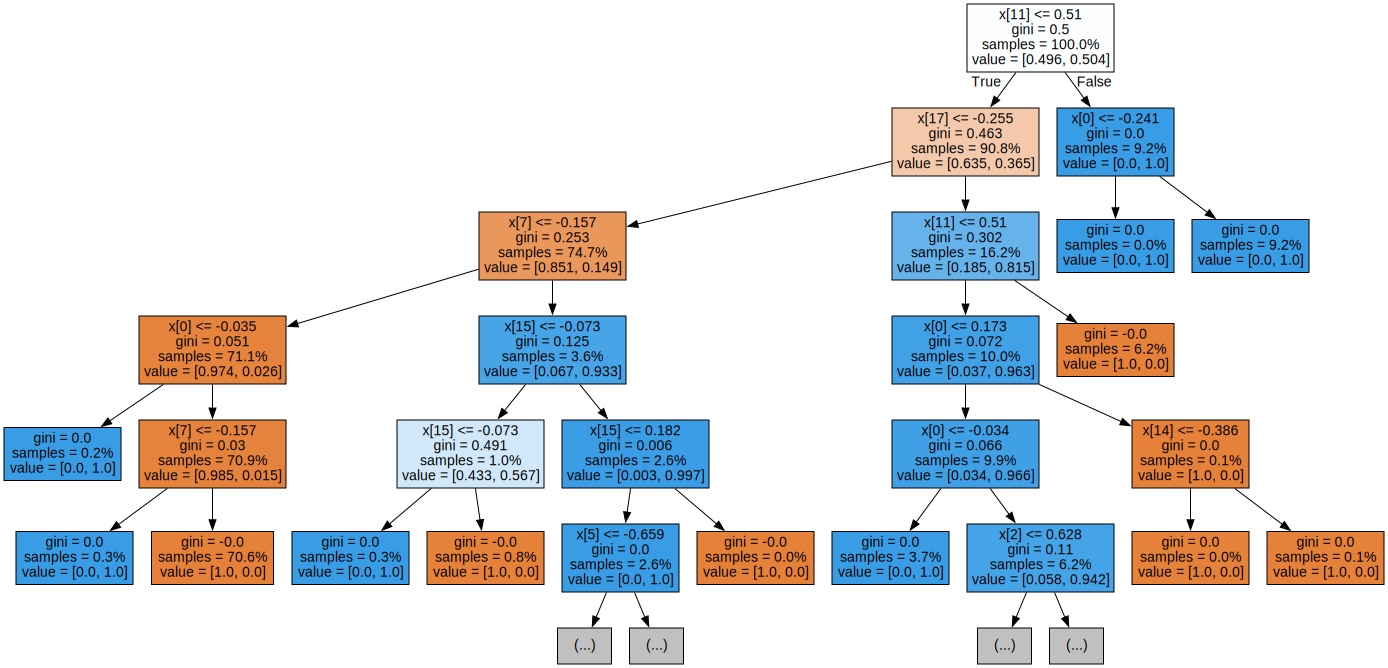

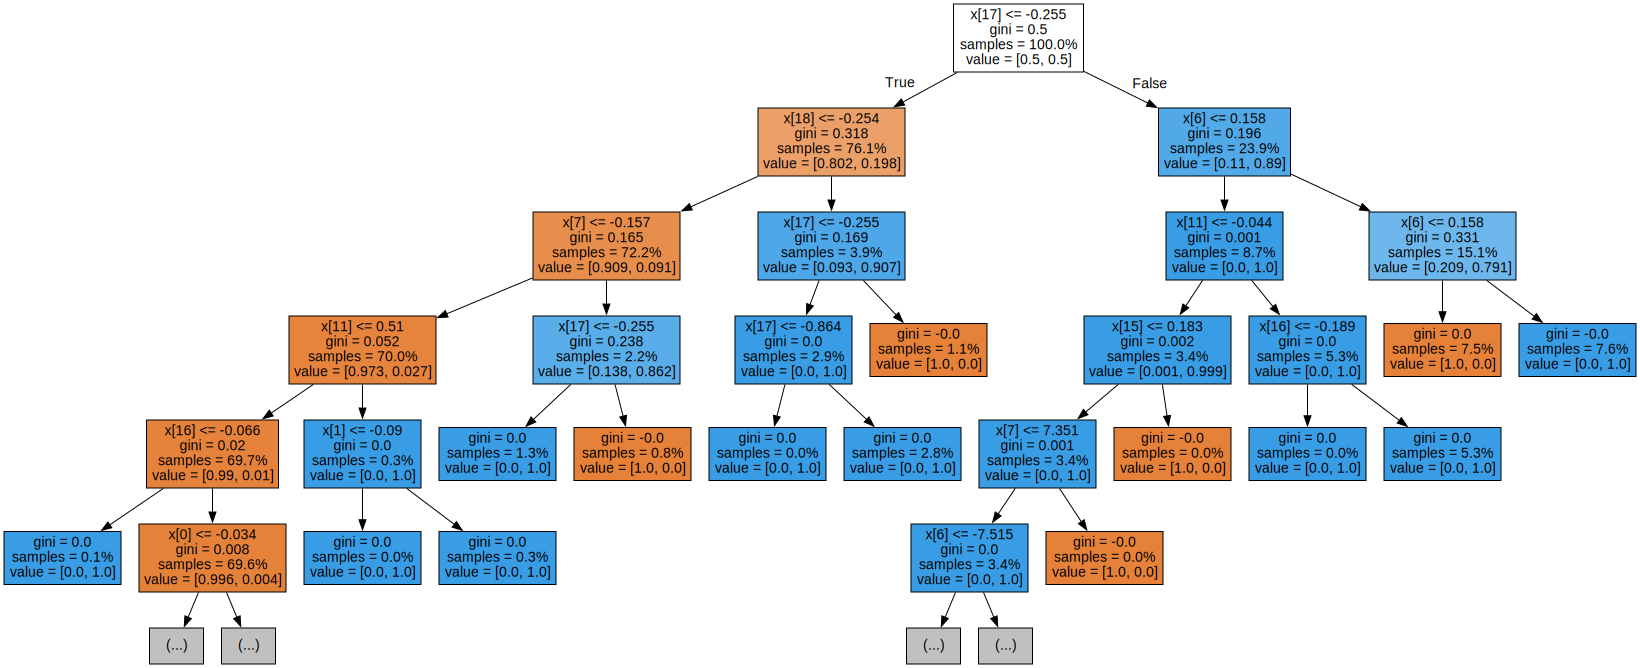

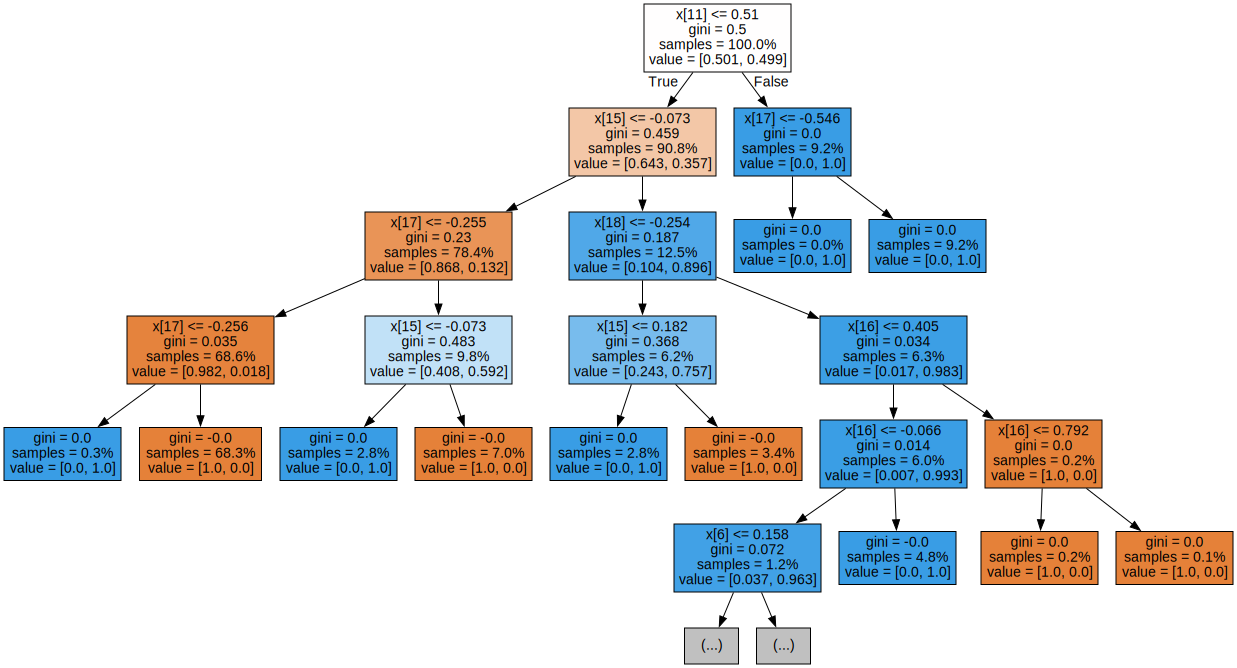

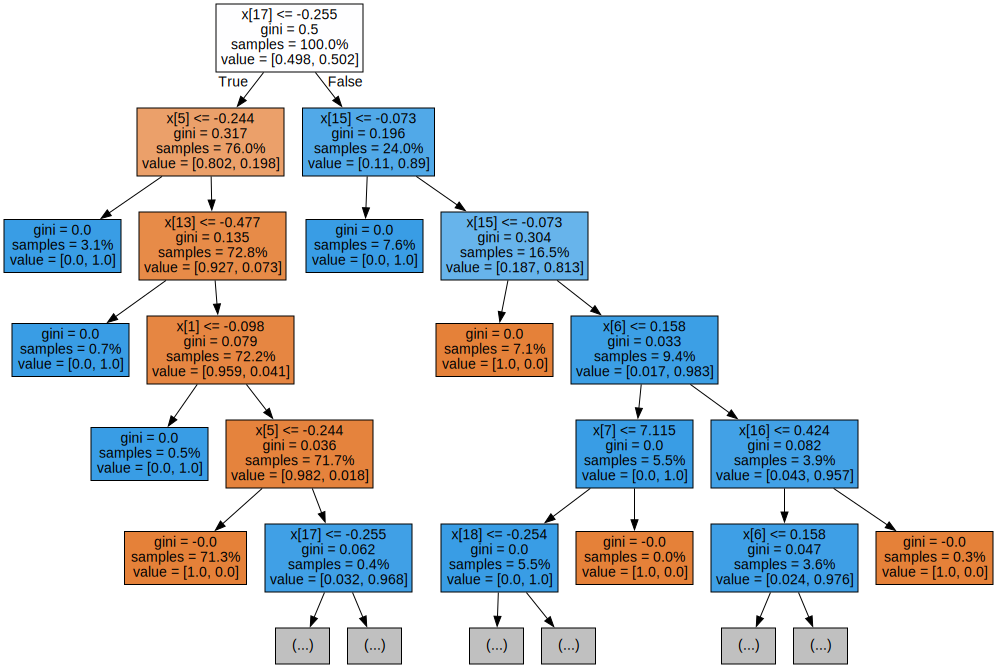

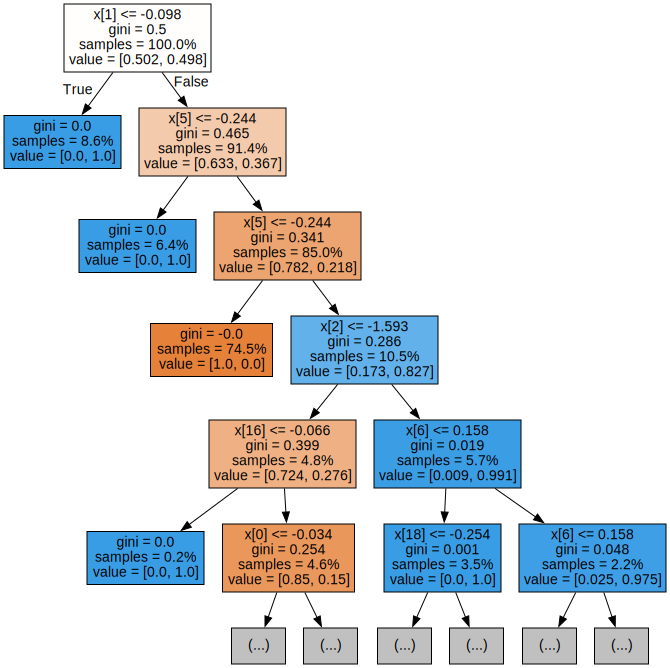

In [84]:
# Export the first three decision trees from the forest
features = np.genfromtxt('../data/medical_regular_data.csv', dtype='str', max_rows=1, delimiter=',')[:-1]
print(features)
for i in range(5):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               #feature_names=features,  
                               filled=True,  
                               max_depth=5, 
                               impurity=True, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [85]:
if DATASET == 'network_data':
    y_pred_network = y_pred
if DATASET == 'medical_data':
    y_pred_medical = y_pred
if False:
    y_pred_combined = np.logical_or(y_pred_medical, y_pred_network)
    accuracy = accuracy_score(test_Y, y_pred_combined)
    precision, recall, f1 = precision_score(test_Y, y_pred_combined), recall_score(test_Y, y_pred_combined), f1_score(test_Y, y_pred_combined)

    print(f"Accuracy:  {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")

In [86]:
e = torch.empty(0)
a = torch.tensor([1, 2, 3])
print(torch.concat((e, a), dim=-1))
a = torch.tensor([[1, 2], [5, 10]])
b = torch.tensor([[2, 7]])
c = torch.tensor([[6, 11]])
idc = torch.sum(torch.logical_and(b < a, a < c), dim=1) == 2
a[idc]

tensor([1., 2., 3.])


tensor([[ 5, 10]])